In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('hippocampus_volume_relevance_DELCODE.xlsx', sheet_name='DELCODE_LRP_CMP')
#print(df)
sid = df['SID']
grp = df['prmdiag']
age = df['age']
sex = df['sex_bin_1female']
tiv = df['TIV_CAT12']
field = df['FieldStrength']
grpbin = (grp > 0) # 0=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataDELCODE_CN = sorted(glob.glob('mwp1_CAT12_DELCODE/0_CN/*.nii.gz'))
dataDELCODE_MCI = sorted(glob.glob('mwp1_CAT12_DELCODE/2_MCI/*.nii.gz'))
dataDELCODE_AD = sorted(glob.glob('mwp1_CAT12_DELCODE/5_AD/*.nii.gz'))
dataFiles = dataDELCODE_CN + dataDELCODE_MCI + dataDELCODE_AD
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  474  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%s' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load original data from disk
import h5py
hf = h5py.File('orig_images_DELCODE_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(474, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [6]:
# helper function to obtain performance result values
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    return bacc, sen, spec, ppv, npv, f1

validating model model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5


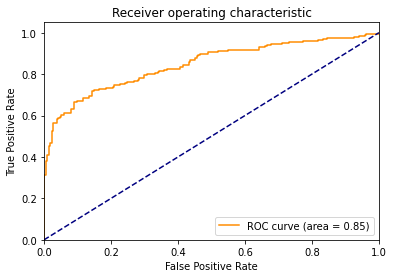

AUC for MCI vs. CN = 0.779
AUC for AD vs. CN = 0.947
Acc for MCI vs. CN = 73.2
Acc for AD vs. CN = 90.3
confusion matrix
[[196  19]
 [  0   0]
 [ 80  75]
 [ 12  92]]


In [7]:
# Split data into training/validation and holdout test data
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import models
import tensorflow as tf
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
bacc_AD, bacc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
f1_AD, f1_MCI = [], []

batch_size = 20

for k in (1,):
    print('validating model model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5')
    mymodel = models.load_model('model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5')
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [2,5]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.zeros((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100

    print('AUC for MCI vs. CN = %0.3f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[5])
    print('Acc for MCI vs. CN = %0.1f' % acc[2])
    print('Acc for AD vs. CN = %0.1f' % acc[5])
    auc_AD.append(roc_auc[5])
    auc_MCI.append(roc_auc[2])
    acc_AD.append(acc[5])
    acc_MCI.append(acc[2])
    
    print('confusion matrix')
    confmat = confusion_matrix(grps.Group, np.round(pred[:, 1]))
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    bacc_MCI.append(bacc); sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    bacc_AD.append(bacc); sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [8]:
# print model performance summary

print('AUC for MCI vs. CN = %0.3f' % auc_MCI[0])
print('AUC for AD vs. CN = %0.3f' % auc_AD[0])
print('Acc for MCI vs. CN = %0.3f' % acc_MCI[0])
print('Acc for AD vs. CN = %0.3f' % acc_AD[0])
print('Bacc for MCI vs. CN = %0.3f' % bacc_MCI[0])
print('Bacc for AD vs. CN = %0.3f' % bacc_AD[0])
print('Sen for MCI vs. CN = %0.3f' % sen_MCI[0])
print('Sen for AD vs. CN = %0.3f' % sen_AD[0])
print('Spec for MCI vs. CN = %0.3f' % spec_MCI[0])
print('Spec for AD vs. CN = %0.3f' % spec_AD[0])
print('PPV for MCI vs. CN = %0.3f' % ppv_MCI[0])
print('PPV for AD vs. CN = %0.3f' % ppv_AD[0])
print('NPV for MCI vs. CN = %0.3f' % npv_MCI[0])
print('NPV for AD vs. CN = %0.3f' % npv_AD[0])
print('F1 for MCI vs. CN = %0.3f' % f1_MCI[0])
print('F1 for AD vs. CN = %0.3f' % f1_AD[0])

AUC for MCI vs. CN = 0.779
AUC for AD vs. CN = 0.947
Acc for MCI vs. CN = 73.243
Acc for AD vs. CN = 90.282
Bacc for MCI vs. CN = 0.698
Bacc for AD vs. CN = 0.898
Sen for MCI vs. CN = 0.484
Sen for AD vs. CN = 0.885
Spec for MCI vs. CN = 0.912
Spec for AD vs. CN = 0.912
PPV for MCI vs. CN = 0.798
PPV for AD vs. CN = 0.829
NPV for MCI vs. CN = 0.710
NPV for AD vs. CN = 0.942
F1 for MCI vs. CN = 0.602
F1 for AD vs. CN = 0.856
